### Limma voom analysis of AD/PD dataset

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(50))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
##load ATAC-seq raw read counts
#data=read.table('../adpd.atac.idr.counts.txt.gz',header=TRUE,sep='\t')

##concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
#rownames(data)=paste(data$chrom,data$start,data$end,sep="_")
#data$chrom=NULL
#data$start=NULL
#data$end=NULL

#data=data[rowSums(data)>0,]


In [2]:
#load ATAC-seq data normalized counts. These were generated below w/ voom function 
data=read.table("idr.voom.qnorm.txt",header=TRUE,sep='\t',row.names=1)


In [3]:
E=data

In [7]:
head(data)

,ADAD_CAUD_00_0281,ADAD_CAUD_00_0387,ADAD_CAUD_01_0164,ADAD_CAUD_01_1400,ADAD_CAUD_06_0194,ADAD_CAUD_06_1486,ADAD_CAUD_07_0787,ADAD_CAUD_12829xx,ADAD_CAUD_23156xx,ADAD_CAUD_24281xx,⋯,LRRK_MDTG_01_39,LRRK_MDTG_04_10,LRRK_MDTG_10_37,LRRK_MDTG_13_60,LRRK_PTMN_01_39,LRRK_PTMN_04_10,LRRK_PTMN_10_37,LRRK_PTMN_13_60,LRRK_SUNI_04_10,LRRK_SUNI_10_37
chr1_10015_10231,12,16,22,12,14,20,12,22,16,10,⋯,3,2,14,18,0,4,12,9,22,26
chr1_181363_181563,1,6,4,2,10,6,1,9,1,3,⋯,1,5,2,14,0,4,7,4,8,18
chr1_183716_183916,7,4,4,12,2,10,19,14,8,10,⋯,1,19,10,21,3,16,8,6,20,13
chr1_184083_184283,11,8,4,11,2,19,20,27,6,18,⋯,1,20,26,25,3,22,18,11,26,24
chr1_184370_184570,7,6,6,0,6,9,6,11,5,9,⋯,5,16,11,18,1,13,7,4,23,15
chr1_190744_191148,84,95,136,110,43,163,97,186,66,158,⋯,6,70,122,46,8,78,46,36,79,93


In [4]:
#load the metadata
batches=read.table("../batches.filtered.csv",header=TRUE,sep='\t')

In [5]:
tail(batches)

,Sample,NewName,Type,TypeMod,Region,RegionMod,Cohort,TissueCenter,Batch,Gender,expired_age,PMI,ApoE
407,LRRK_PTMN_01_39,PD_01_39_LRRK_PTMN_X025_S12_L022_B1_T2_P046,LRRK,ADPD,PTMN,PTMN,PD,UA,PD_X025,Male,85,2.00,3_4
408,LRRK_PTMN_04_10,PD_04_10_LRRK_PTMN_X026_S10_L041_B1_T1_P050,LRRK,ADPD,PTMN,PTMN,PD,UA,PD_X026,Male,77,1.66,3_3
409,LRRK_PTMN_10_37,PD_10_37_LRRK_PTMN_X015_S05_L033_B1_T1_P026,LRRK,ADPD,PTMN,PTMN,PD,UA,PD_X015,Female,84,5.00,3_3
410,LRRK_PTMN_13_60,PD_13_60_LRRK_PTMN_X007_S07_L061_B1_T1_P010,LRRK,ADPD,PTMN,PTMN,PD,UA,PD_X007,Male,89,3.82,3_3
411,LRRK_SUNI_04_10,PD_04_10_LRRK_SUNI_X022_S06_L035_B1_T1_P043,LRRK,ADPD,SUNI,SUNI,PD,UA,PD_X022,Male,77,1.66,3_3
412,LRRK_SUNI_10_37,PD_10_37_LRRK_SUNI_X010_S11_L045_B1_T1_P016,LRRK,ADPD,SUNI,SUNI,PD,UA,PD_X010,Female,84,5.00,3_3


## Normalize the data with voom 

In [11]:
tpm=voom(data,normalize.method = "quantile")
E=tpm$E
E=round(E,2)

In [19]:
head(E)

,ADAD_CAUD_00_0281,ADAD_CAUD_00_0387,ADAD_CAUD_01_0164,ADAD_CAUD_01_1400,ADAD_CAUD_06_0194,ADAD_CAUD_06_1486,ADAD_CAUD_07_0787,ADAD_CAUD_12829xx,ADAD_CAUD_23156xx,ADAD_CAUD_24281xx,⋯,LRRK_MDTG_01_39,LRRK_MDTG_04_10,LRRK_MDTG_10_37,LRRK_MDTG_13_60,LRRK_PTMN_01_39,LRRK_PTMN_04_10,LRRK_PTMN_10_37,LRRK_PTMN_13_60,LRRK_SUNI_04_10,LRRK_SUNI_10_37
chr1_10015_10231,-1.00,-0.46,0.11,-1.12,-0.94,-0.27,-1.19,0.02,-1.13,-1.23,⋯,-2.07,-3.73,-0.92,-0.87,-4.16,-3.77,-1.44,-1.78,-0.58,-0.08
chr1_181363_181563,-4.07,-1.99,-1.87,-3.38,-1.56,-1.94,-4.37,-1.13,-4.36,-2.69,⋯,-3.07,-2.59,-3.19,-1.19,-4.16,-3.77,-2.31,-2.94,-1.99,-0.66
chr1_183716_183916,-1.78,-2.59,-1.87,-1.12,-3.99,-1.21,-0.52,-0.55,-2.01,-1.23,⋯,-3.07,-0.84,-1.35,-0.67,-2.03,-1.54,-2.11,-2.35,-0.71,-1.19
chr1_184083_184283,-1.13,-1.54,-1.87,-1.24,-3.99,-0.33,-0.45,0.27,-2.37,-0.50,⋯,-3.07,-0.76,-0.08,-0.45,-2.03,-1.10,-0.80,-1.50,-0.35,-0.21
chr1_184370_184570,-1.78,-1.99,-1.41,-5.48,-2.39,-1.36,-2.17,-0.86,-2.61,-1.36,⋯,-1.46,-1.07,-1.23,-0.87,-3.07,-1.84,-2.31,-2.94,-0.52,-0.95
chr1_190744_191148,1.81,2.01,2.15,1.67,1.13,2.29,1.70,2.46,0.75,2.08,⋯,-1.21,1.05,2.01,0.36,-0.69,0.68,0.58,0.09,1.17,1.77


In [20]:
#save the normalized data so we can load those values directly next time
write.table(E,file="idr.voom.qnorm.txt",quote=FALSE,sep='\t')

## Perform PCA analysis before SVA correction, find which covariates account for axes of variation

In [23]:
data.pca=prcomp(t(E))

In [24]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))


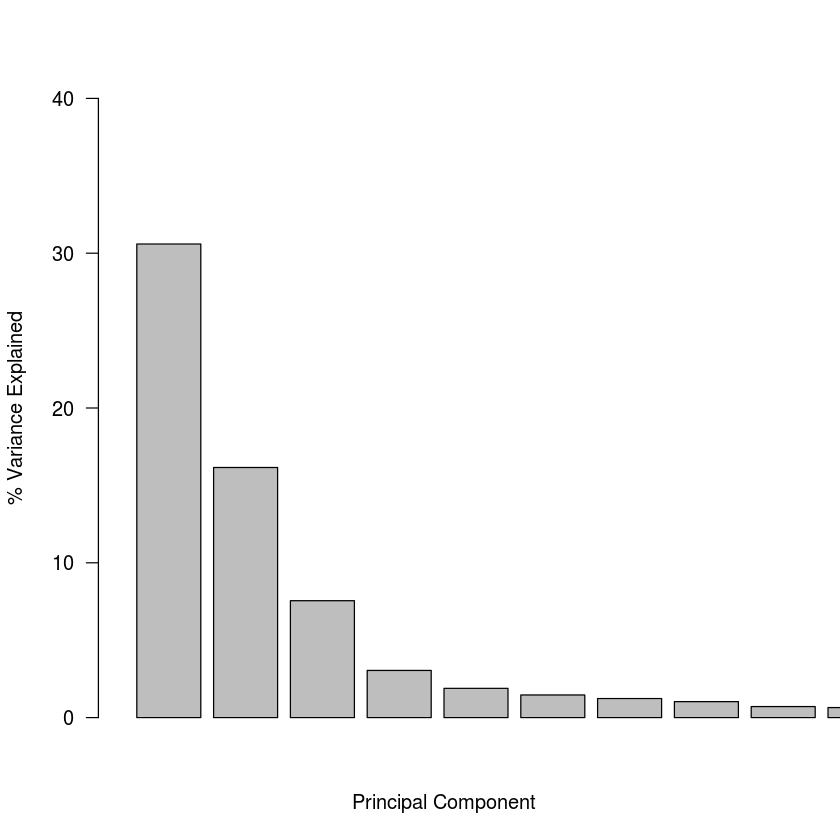

In [46]:
barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,40), xlim=c(0,10))

In [29]:
nrow(E)

[1] 385725

In [26]:
var_explained[0:10]

[1] "30.59" "16.16" "7.55"  "3.05"  "1.89"  "1.46"  "1.23"  "1.03"  "0.71" 
[10] "0.65"

In [27]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)

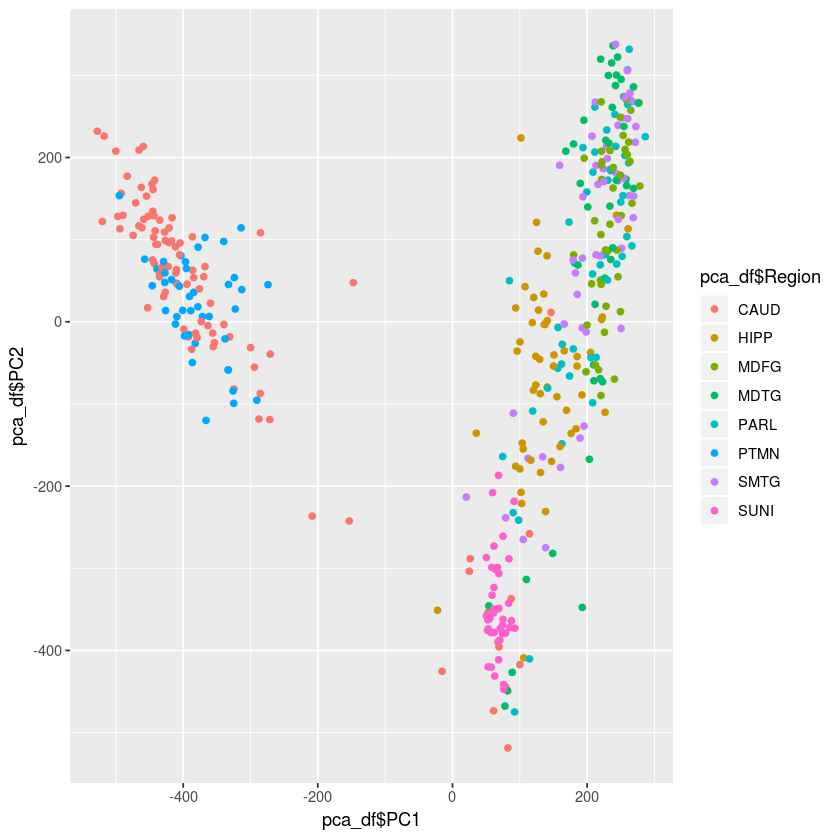

In [28]:
ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Region))+
geom_point()

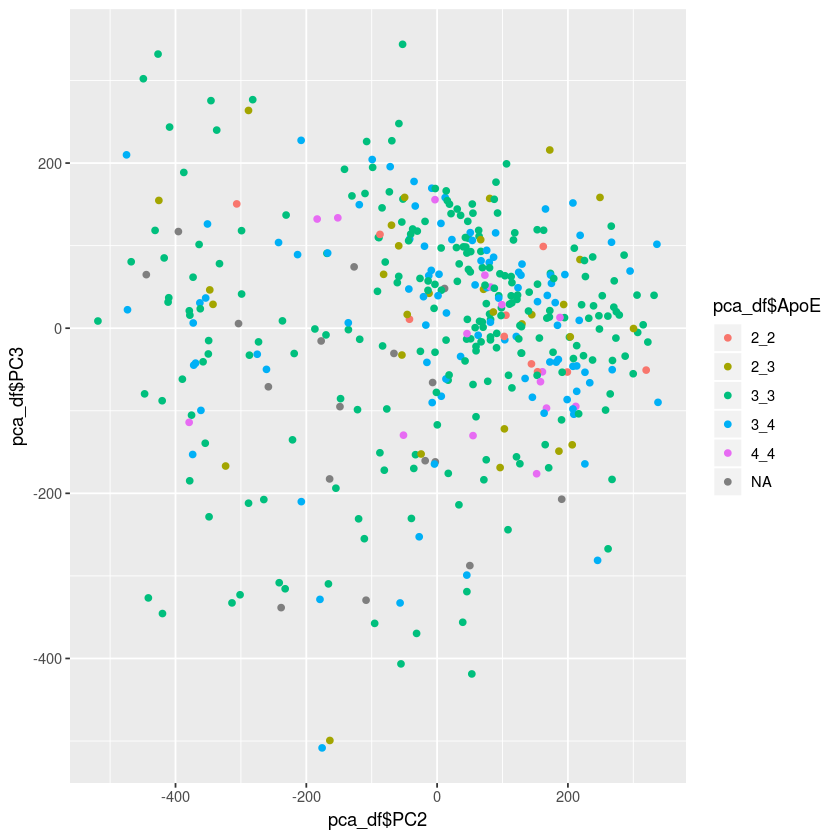

In [56]:
ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$ApoE))+
geom_point()
#Type	TypeMod	Region	RegionMod	Cohort	TissueCenter	Batch	Gender	expired_age	PMI	ApoE

In [67]:
E_nonzero_var=E[apply(E, 1, var) >= 0.01, ]
nrow(E_nonzero)
nrow(E)
#confirm that we don't have low-variance peaks in the data 


In [450]:
Grouping <- factor(paste0(batches$Cohort,".",batches$RegionMod, ".", batches$TypeMod))

In [451]:
batches$Grouping=Grouping

In [452]:
colSums(is.na(batches))

Sample      NewName         Type      TypeMod       Region    RegionMod 
           0            0            0            0            0            0 
      Cohort TissueCenter        Batch       Gender  expired_age          PMI 
           0            0            0            0            0            0 
        ApoE     Grouping 
           0            0

In [447]:
#SVA can't handle NA values, so we have no choice but to interpolate to the mode for missing entries in PMI & ApoE 
batches$ApoE[is.na(batches$ApoE)]='3_3'
batches$PMI[is.na(batches$PMI)]=mean(na.omit(batches$PMI))

In [448]:
mod0=model.matrix(~1,data=batches)
mod1=model.matrix(~Grouping,data=batches)#+Gender+expired_age+PMI+TissueCenter,data=batches)#+Cohort+ApoE+Batch,data=batches)
#Note:  Batch is perfectly correlated with other covariates, must be excluded from sva to avoid
# 'system is computationally singular' error 

In [449]:
ncol(mod1)

[1] 40

In [383]:
mod1

(Intercept),GroupingAD.CAUD.CTRL,GroupingAD.CAUD.LOAD,GroupingAD.HIPP.ADAD,GroupingAD.HIPP.CTRL,GroupingAD.HIPP.LOAD,GroupingAD.PARL.ADAD,GroupingAD.PARL.CTRL,GroupingAD.PARL.LOAD,GroupingAD.SMTG.ADAD,⋯,GroupingPD.MDFG.LOPD,GroupingPD.PTMN.ADPD,GroupingPD.PTMN.CTRL,GroupingPD.PTMN.LOPD,GroupingPD.SMTG.ADPD,GroupingPD.SMTG.CTRL,GroupingPD.SMTG.LOPD,GroupingPD.SUNI.ADPD,GroupingPD.SUNI.CTRL,GroupingPD.SUNI.LOPD
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [373]:
#compute sva on the 10k most variable rows 

In [384]:
sva.obj=sva(E,mod1,mod0,vfilter=10000)#,n.sv = n.sv,vfilter=10000)

Number of significant surrogate variables is:  18 
Iteration (out of 5 ):1  2  3  4  5  

In [ ]:
sva.obj

In [387]:
sur_var=data.frame(sva.obj$sv)

In [388]:
ncol(sur_var)

[1] 18

In [ ]:
summary(lm(sva.obj$sv~batches$TissueCenter))

In [ ]:
summary(lm(sva.obj$sv~batches$Batch))

In [ ]:
summary(lm(sva.obj$sv~batches$Gender))

In [ ]:
summary(lm(sva.obj$sv~batches$expired_age))

In [ ]:
summary(lm(sva.obj$sv~batches$PMI))

In [ ]:
summary(lm(sva.obj$sv~batches$ApoE))

In [391]:
#Now, we include all covariates and surrogate variables 
mod2=model.matrix(~Grouping+Gender+expired_age+PMI+TissueCenter+ApoE+Batch,data=batches)

In [392]:
full.design.sv=cbind(mod2,sur_var)

In [393]:
#save the full design so we don't have to run SVA next time 
write.table(full.design.sv,file="full.design.sv.txt",quote=FALSE,sep='\t')

In [6]:
full.design.sv=read.table("full.design.sv.txt",header=TRUE,sep='\t')

In [7]:
full.design.sv

X.Intercept.,GroupingAD.CAUD.CTRL,GroupingAD.CAUD.LOAD,GroupingAD.HIPP.ADAD,GroupingAD.HIPP.CTRL,GroupingAD.HIPP.LOAD,GroupingAD.PARL.ADAD,GroupingAD.PARL.CTRL,GroupingAD.PARL.LOAD,GroupingAD.SMTG.ADAD,⋯,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
1,0,0,0,0,0,0,0,0,0,⋯,-0.0581871026,-0.022144185,0.0251018108,-0.0049501920,0.012274062,-0.116110890,0.008563260,-0.011092600,0.037102854,-0.008307799
1,0,0,0,0,0,0,0,0,0,⋯,-0.0053311154,0.061196642,0.0032175404,-0.0590215300,-0.060287325,-0.032046992,-0.051412270,0.011072245,0.004016369,-0.049918781
1,0,0,0,0,0,0,0,0,0,⋯,0.0557649417,0.015355997,0.0505424998,-0.0274422873,0.062510248,-0.014949786,-0.043461253,-0.016316615,-0.011074452,-0.016057842
1,0,0,0,0,0,0,0,0,0,⋯,0.0159232599,-0.018480697,0.0249656604,0.0303933154,-0.005094346,-0.078115592,-0.021742084,0.030668728,0.035462087,-0.070009429
1,0,0,0,0,0,0,0,0,0,⋯,-0.0608882566,-0.045657233,-0.0081883785,0.0265980269,0.066277722,0.049227693,-0.002314142,-0.011396957,0.077486466,0.014683453
1,0,0,0,0,0,0,0,0,0,⋯,0.0048867810,0.001150668,-0.0140781034,0.0704561719,-0.004102016,0.045216820,-0.018539056,-0.043960198,0.057396842,0.034151717
1,0,0,0,0,0,0,0,0,0,⋯,0.0767462813,-0.015654495,0.0476972144,-0.0135482431,-0.067632392,-0.015472514,-0.054440040,-0.065730697,0.009097681,-0.057039189
1,0,0,0,0,0,0,0,0,0,⋯,0.0266764659,-0.003310350,-0.0171830549,0.0371426545,0.077732589,-0.050126549,-0.027459335,-0.033424623,0.093732076,0.024392074
1,0,0,0,0,0,0,0,0,0,⋯,-0.0124712618,-0.062885192,-0.0072719627,0.0360012680,0.007365229,0.011476795,-0.083943673,0.049473130,-0.059317379,0.073283993
1,0,0,0,0,0,0,0,0,0,⋯,-0.0379773752,-0.024410829,-0.0127511638,0.0268034140,-0.097046495,0.058912820,-0.048862509,0.004475007,0.034191226,0.004284993


### perform pca on the "cleaned" matrix with surrogate variable contributions removes 

In [400]:
cleanY = function(y, mod, svs) {
    X = cbind(mod, svs)
    print(nrow(X))
    print(ncol(X))
    Hat = solve(t(X) %*% X) %*% t(X)
    beta = (Hat %*% t(y))
    rm(Hat)
    gc()
    P = ncol(mod)
    return(y - t(as.matrix(X[,-c(1:P)]) %*% beta[-c(1:P),]))
}

In [410]:
cleaned_E=removeBatchEffect(E,covariates=sur_var)

In [403]:
cleaned_E=cleanY(as.matrix(E),mod1,sur_var)

[1] 412
[1] 48


ERROR: Error in t(X) %*% X: requires numeric/complex matrix/vector arguments


In [411]:
data.pca=prcomp(t(cleaned_E))

In [416]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))

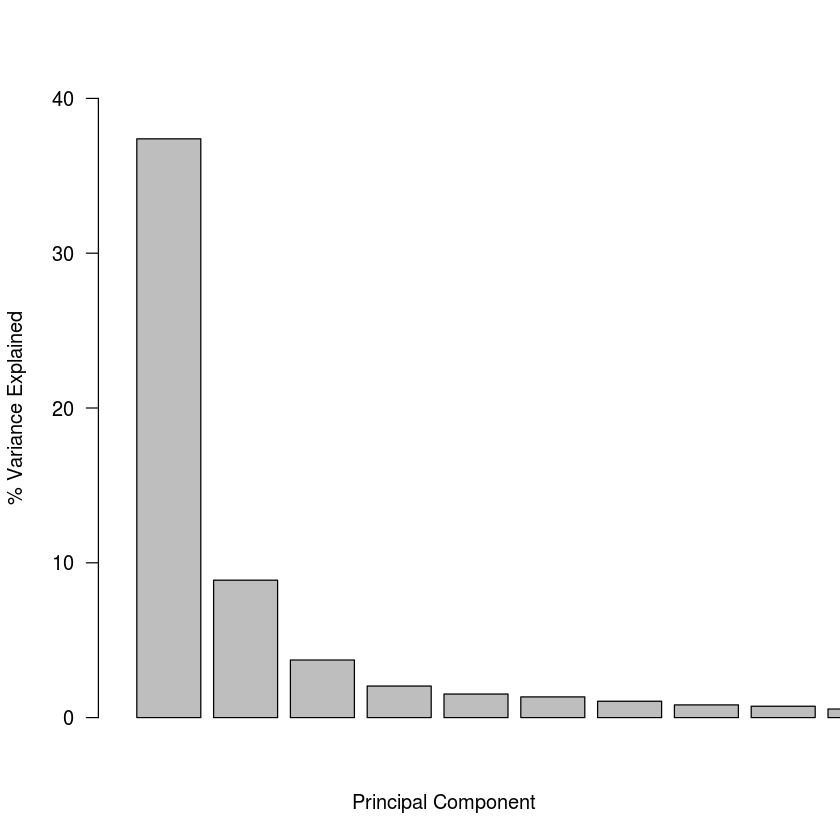

In [417]:
barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,40), xlim=c(0,10))

In [418]:
var_explained[0:10]

[1] "37.39" "8.88"  "3.72"  "2.04"  "1.52"  "1.34"  "1.06"  "0.82"  "0.73" 
[10] "0.56"

In [419]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)

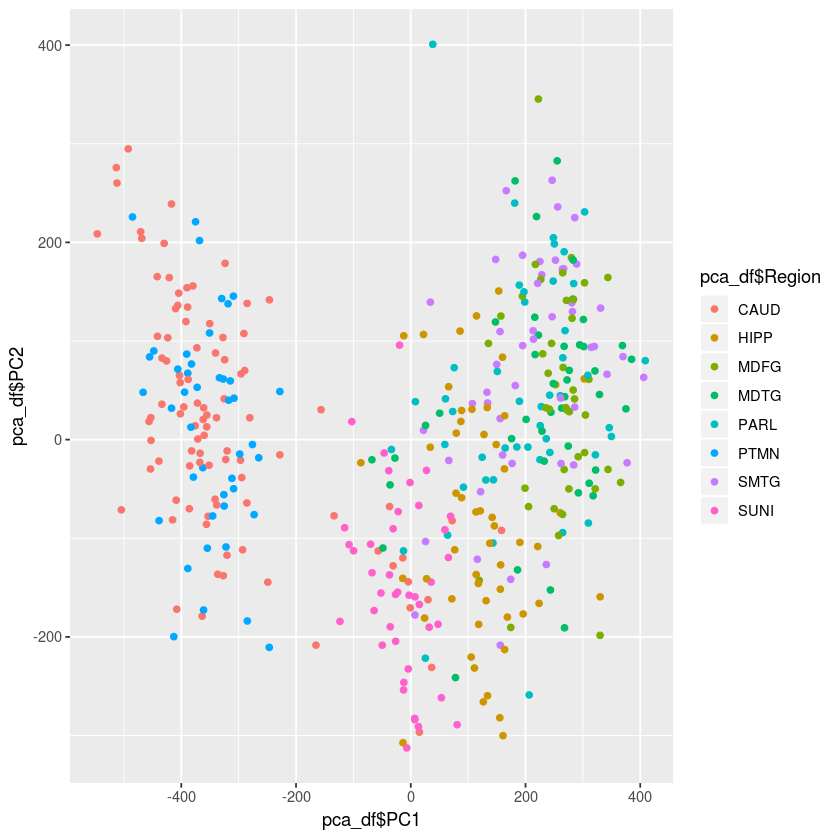

In [420]:
ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Region))+
geom_point()

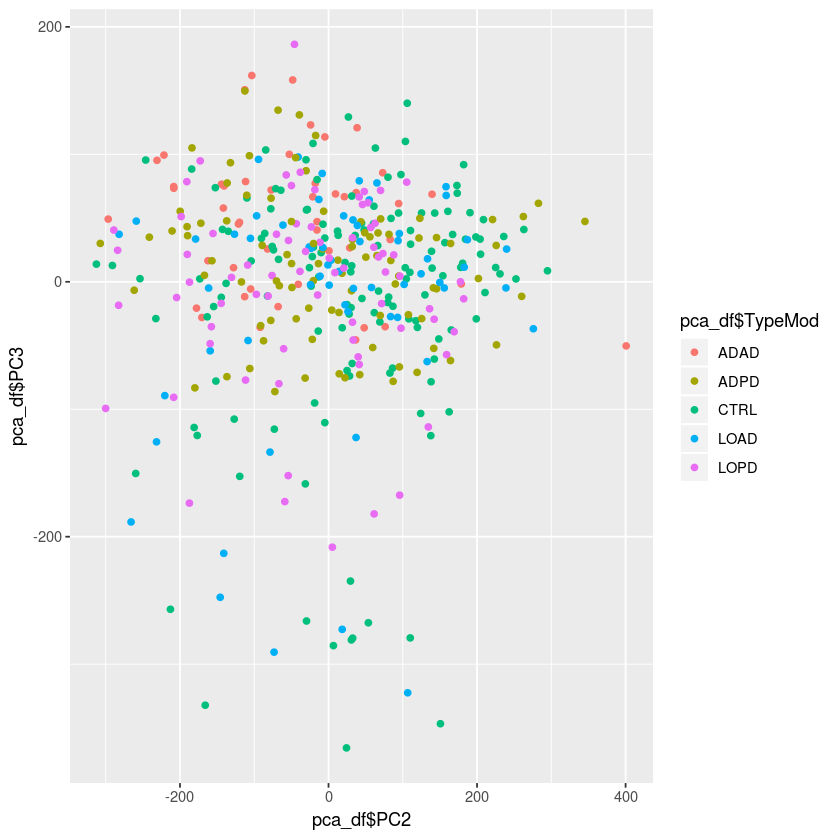

In [438]:
ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$TypeMod))+
geom_point()

### fit model with limma 

In [8]:
fit <- lmFit(E,full.design.sv)

Coefficients not estimable: TissueCenterWUSTL BatchPD_X031 


Warning message:
“Partial NA coefficients for 385725 probe(s)”

In [9]:
names(full.design.sv)


[1] "X.Intercept."         "GroupingAD.CAUD.CTRL" "GroupingAD.CAUD.LOAD"
  [4] "GroupingAD.HIPP.ADAD" "GroupingAD.HIPP.CTRL" "GroupingAD.HIPP.LOAD"
  [7] "GroupingAD.PARL.ADAD" "GroupingAD.PARL.CTRL" "GroupingAD.PARL.LOAD"
 [10] "GroupingAD.SMTG.ADAD" "GroupingAD.SMTG.CTRL" "GroupingAD.SMTG.LOAD"
 [13] "GroupingPD.CAUD.ADPD" "GroupingPD.CAUD.CTRL" "GroupingPD.CAUD.LOPD"
 [16] "GroupingPD.HIPP.ADPD" "GroupingPD.HIPP.CTRL" "GroupingPD.HIPP.LOPD"
 [19] "GroupingPD.MDFG.ADPD" "GroupingPD.MDFG.CTRL" "GroupingPD.MDFG.LOPD"
 [22] "GroupingPD.PTMN.ADPD" "GroupingPD.PTMN.CTRL" "GroupingPD.PTMN.LOPD"
 [25] "GroupingPD.SMTG.ADPD" "GroupingPD.SMTG.CTRL" "GroupingPD.SMTG.LOPD"
 [28] "GroupingPD.SUNI.ADPD" "GroupingPD.SUNI.CTRL" "GroupingPD.SUNI.LOPD"
 [31] "GenderMale"           "expired_age"          "PMI"                 
 [34] "TissueCenterUW"       "TissueCenterWUSTL"    "ApoE2_3"             
 [37] "ApoE3_3"              "ApoE3_4"              "ApoE4_4"             
 [40] "BatchAD_X002"         "BatchAD_X003"         "BatchAD_X004"        
 [43] "BatchAD_X005"         "BatchAD_X006"         "BatchAD_X007"        
 [46] "BatchAD_X008"         "BatchAD_X009"         "BatchAD_X010"        
 [49] "BatchAD_X011"         "BatchAD_X012"         "BatchAD_X013"        
 [52] "BatchAD_X014"         "BatchAD_X015"         "BatchAD_X016"        
 [55] "BatchAD_X017"         "BatchAD_X018"         "BatchPD_X001"        
 [58] "BatchPD_X002"         "BatchPD_X003"         "BatchPD_X004"        
 [61] "BatchPD_X005"         "BatchPD_X006"         "BatchPD_X007"        
 [64] "BatchPD_X008"         "BatchPD_X009"         "BatchPD_X010"        
 [67] "BatchPD_X011"         "BatchPD_X012"         "BatchPD_X013"        
 [70] "BatchPD_X014"         "BatchPD_X015"         "BatchPD_X016"        
 [73] "BatchPD_X017"         "BatchPD_X018"         "BatchPD_X019"        
 [76] "BatchPD_X020"         "BatchPD_X021"         "BatchPD_X022"        
 [79] "BatchPD_X023"         "BatchPD_X024"         "BatchPD_X025"        
 [82] "BatchPD_X026"         "BatchPD_X027"         "BatchPD_X028"        
 [85] "BatchPD_X029"         "BatchPD_X030"         "BatchPD_X031"        
 [88] "X1"                   "X2"                   "X3"                  
 [91] "X4"                   "X5"                   "X6"                  
 [94] "X7"                   "X8"                   "X9"                  
 [97] "X10"                  "X11"                  "X12"                 
[100] "X13"                  "X14"                  "X15"                 
[103] "X16"                  "X17"                  "X18"

In [10]:
colnames(fit$coefficients)

[1] "X.Intercept."         "GroupingAD.CAUD.CTRL" "GroupingAD.CAUD.LOAD"
  [4] "GroupingAD.HIPP.ADAD" "GroupingAD.HIPP.CTRL" "GroupingAD.HIPP.LOAD"
  [7] "GroupingAD.PARL.ADAD" "GroupingAD.PARL.CTRL" "GroupingAD.PARL.LOAD"
 [10] "GroupingAD.SMTG.ADAD" "GroupingAD.SMTG.CTRL" "GroupingAD.SMTG.LOAD"
 [13] "GroupingPD.CAUD.ADPD" "GroupingPD.CAUD.CTRL" "GroupingPD.CAUD.LOPD"
 [16] "GroupingPD.HIPP.ADPD" "GroupingPD.HIPP.CTRL" "GroupingPD.HIPP.LOPD"
 [19] "GroupingPD.MDFG.ADPD" "GroupingPD.MDFG.CTRL" "GroupingPD.MDFG.LOPD"
 [22] "GroupingPD.PTMN.ADPD" "GroupingPD.PTMN.CTRL" "GroupingPD.PTMN.LOPD"
 [25] "GroupingPD.SMTG.ADPD" "GroupingPD.SMTG.CTRL" "GroupingPD.SMTG.LOPD"
 [28] "GroupingPD.SUNI.ADPD" "GroupingPD.SUNI.CTRL" "GroupingPD.SUNI.LOPD"
 [31] "GenderMale"           "expired_age"          "PMI"                 
 [34] "TissueCenterUW"       "TissueCenterWUSTL"    "ApoE2_3"             
 [37] "ApoE3_3"              "ApoE3_4"              "ApoE4_4"             
 [40] "BatchAD_X002"         "BatchAD_X003"         "BatchAD_X004"        
 [43] "BatchAD_X005"         "BatchAD_X006"         "BatchAD_X007"        
 [46] "BatchAD_X008"         "BatchAD_X009"         "BatchAD_X010"        
 [49] "BatchAD_X011"         "BatchAD_X012"         "BatchAD_X013"        
 [52] "BatchAD_X014"         "BatchAD_X015"         "BatchAD_X016"        
 [55] "BatchAD_X017"         "BatchAD_X018"         "BatchPD_X001"        
 [58] "BatchPD_X002"         "BatchPD_X003"         "BatchPD_X004"        
 [61] "BatchPD_X005"         "BatchPD_X006"         "BatchPD_X007"        
 [64] "BatchPD_X008"         "BatchPD_X009"         "BatchPD_X010"        
 [67] "BatchPD_X011"         "BatchPD_X012"         "BatchPD_X013"        
 [70] "BatchPD_X014"         "BatchPD_X015"         "BatchPD_X016"        
 [73] "BatchPD_X017"         "BatchPD_X018"         "BatchPD_X019"        
 [76] "BatchPD_X020"         "BatchPD_X021"         "BatchPD_X022"        
 [79] "BatchPD_X023"         "BatchPD_X024"         "BatchPD_X025"        
 [82] "BatchPD_X026"         "BatchPD_X027"         "BatchPD_X028"        
 [85] "BatchPD_X029"         "BatchPD_X030"         "BatchPD_X031"        
 [88] "X1"                   "X2"                   "X3"                  
 [91] "X4"                   "X5"                   "X6"                  
 [94] "X7"                   "X8"                   "X9"                  
 [97] "X10"                  "X11"                  "X12"                 
[100] "X13"                  "X14"                  "X15"                 
[103] "X16"                  "X17"                  "X18"

###  PD, CAUD

In [11]:
#create contrasts of interest 
pd.caud.cont.matrix=makeContrasts(
                          pd_caud_adpd_vs_lopd="GroupingPD.CAUD.ADPD - GroupingPD.CAUD.LOPD",
                          pd_caud_adpd_vs_ctrl="GroupingPD.CAUD.ADPD - GroupingPD.CAUD.CTRL",
                          pd_caud_lopd_vs_ctrl="GroupingPD.CAUD.LOPD - GroupingPD.CAUD.CTRL",
                          levels=full.design.sv)


In [12]:
fit2=contrasts.fit(fit,pd.caud.cont.matrix)
e=eBayes(fit2)
comparisons=colnames(pd.caud.cont.matrix)

In [15]:
comparisons

[1] "pd_caud_adpd_vs_lopd" "pd_caud_adpd_vs_ctrl" "pd_caud_lopd_vs_ctrl"

In [14]:
for(i in seq(1,length(comparisons)))
{
  tab<-topTable(e, number=nrow(e),coef=i,p.value = 0.05)
  up=sum(tab$logFC>0)
  down=sum(tab$logFC<0)
  sig=nrow(tab)
  curtitle=paste(comparisons[i],'\n','sig:',sig,'\n','up:',up,'\n','down:',down,'\n')
  print(curtitle)
  vals=topTable(e,number=nrow(e),coef=i)
  vals$pscaled=-10*log10(vals$adj.P.Val)
  vals$sig=vals$adj.P.Val<0.05
  png(paste("sva_volcano_diff",comparisons[i],".png",sep=""))
  print(ggplot(data=vals,
               aes(y=vals$pscaled,x=vals$logFC,color=vals$sig))+
   geom_point()+
   xlab("log2(FC)")+
   ylab("-10*log10(pval)")+
   ggtitle(curtitle))
  dev.off() 
  write.table(tab,file=paste("sva_diff_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = TRUE,col.names = TRUE)
}

[1] "pd_caud_adpd_vs_lopd \n sig: 0 \n up: 0 \n down: 0 \n"
[1] "pd_caud_adpd_vs_ctrl \n sig: 41 \n up: 26 \n down: 15 \n"
[1] "pd_caud_lopd_vs_ctrl \n sig: 24 \n up: 12 \n down: 12 \n"
